In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

# 데이터 클렌징 및 가공

In [2]:
df1 = pd.read_csv('/content/drive/MyDrive/Study/파이썬 머신러닝 완벽가이드/data/자전거/train.csv', parse_dates=['datetime'])
print(df1.info())
df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
None


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
bike_df = pd.read_csv('/content/drive/MyDrive/Study/파이썬 머신러닝 완벽가이드/data/자전거/train.csv')
print(bike_df.shape)

bike_df.sample(6)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
9037,2012-08-18 22:00:00,3,0,0,1,27.06,31.060,61,0.0000,90,171,261
8863,2012-08-11 16:00:00,3,0,0,1,32.80,36.365,46,19.9995,227,304,531
9133,2012-09-03 22:00:00,3,1,0,2,28.70,33.335,84,8.9981,17,104,121
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14
4034,2011-09-19 03:00:00,3,0,1,2,20.50,24.240,77,8.9981,1,4,5
2765,2011-07-04 03:00:00,3,1,0,1,26.24,29.545,78,0.0000,13,13,26


In [4]:
# 데이트 타임 형태로 변환
bike_df['datetime'] = bike_df['datetime'].apply(pd.to_datetime)

# 년 월 일 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)

bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [5]:
drop_columns = ['casual', 'registered', 'datetime']
bike_df.drop(drop_columns, axis=1, inplace=True)

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmse(y, y_pred):
  return np.sqrt(mean_squared_error(y, y_pred))

# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
# log1p -> log.np(1 + x)
def rmsle(y, y_pred):
  log_y = np.log1p(y)
  log_y_pred = np.log1p(y_pred)
  squred_error = (log_y - log_y_pred) ** 2
  return np.sqrt(np.mean(squred_error))

def evaluate_regr(y, y_pred):
  rmsle_val = rmsle(y, y_pred)
  rmse_val = rmse(y, y_pred)
  mae_val = mean_absolute_error(y, y_pred)
  print(f'RMLSE : {rmsle_val:.3f}, RMSE : {rmse_val:.3f}, MAE : {mae_val:.3f}')

# 로그변환, 피처 인코딩

타겟은 로그변환

날짜 칼럼은 원핫인코딩

In [7]:
from sklearn.preprocessing import OneHotEncoder

def oneHotEncoder(col_list, data):
  ohe = OneHotEncoder(sparse=False)
  enoder_df = ohe.fit_transform(data[col_list])
  columns = []
  for col, values in zip(col_list, ohe.categories_):
    for i in values:
      columns.append(col+ '_' +str(i))
  
  return pd.DataFrame(enoder_df, columns=columns)

In [8]:
from sklearn.preprocessing import OneHotEncoder

# 전처리 전
y_target = bike_df['count']
x_features = bike_df.drop('count', axis=1, inplace=False)

# 전처리 후
columns = ['year', 'month','day', 'hour', 'holiday', 'workingday', 'season', 'weather']
y_target_log = np.log1p(bike_df['count'])
x_features_one = pd.concat([x_features, oneHotEncoder(columns, x_features)], axis=1)
x_features_one = x_features_one.drop(columns, axis=1, inplace=False)

# 모델 학습 및 평가

In [9]:
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = False):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  if is_expm1:
    # np.expm1 -> np.exp(y_test) - 1
    y_test = np.expm1(y_test)
    pred = np.expm1(pred) 
  print(f'### {model.__class__.__name__} ###')
  evaluate_regr(y_test, pred)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10, random_state=22)
lasso_reg = Lasso(alpha=0.01, random_state=22)
rf_reg = RandomForestRegressor(n_estimators=500, random_state=22)
xgb_reg = XGBRegressor(n_estimators=500, random_state=22)
lgbm_reg = LGBMRegressor(n_estimators=500, random_state=22)

models = [lr_reg, ridge_reg, lasso_reg, rf_reg, xgb_reg, lgbm_reg]

print('#################### 변환 전 ##############################')
X_train, X_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.3, random_state=0)
for model in models:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = False)

print()

print('#################### 픽쳐만 변환##############################')
X_train, X_test, y_train, y_test = train_test_split(x_features_one, y_target, test_size=0.3, random_state=0)
for model in models:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = False)

print()

print('#################### 타겟만 변환##############################')
X_train, X_test, y_train, y_test = train_test_split(x_features, y_target_log, test_size=0.3, random_state=0)
for model in models:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = True)

print()

print('#################### 픽쳐 타겟 두 개 모두 변환##############################')
X_train, X_test, y_train, y_test = train_test_split(x_features_one, y_target_log, test_size=0.3, random_state=0)
for model in models:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = True)

#################### 변환 전 ##############################
### LinearRegression ###
RMLSE : 1.165, RMSE : 140.900, MAE : 105.924
### Ridge ###
RMLSE : 1.172, RMSE : 140.902, MAE : 105.909
### Lasso ###
RMLSE : 1.166, RMSE : 140.899, MAE : 105.918
### RandomForestRegressor ###
RMLSE : 0.353, RMSE : 45.508, MAE : 28.572
[13:23:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMLSE : 0.549, RMSE : 53.979, MAE : 36.677
### LGBMRegressor ###
RMLSE : 0.443, RMSE : 41.856, MAE : 26.856

#################### 픽쳐만 변환##############################
### LinearRegression ###
RMLSE : 0.857, RMSE : 101.621, MAE : 74.889
### Ridge ###
RMLSE : 0.840, RMSE : 101.605, MAE : 74.796
### Lasso ###
RMLSE : 0.846, RMSE : 101.608, MAE : 74.857
### RandomForestRegressor ###
RMLSE : 0.490, RMSE : 55.723, MAE : 34.960
[13:24:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of 

- 트리기반 모델은 feature가 적을 수록 모델의 성능이 좋아지는 경향이 있음
- 선형기반 모델은 category feature를 원핫인코딩을 해주면 성능이 좋아지는 경향이 있음
- 두 모델 모두 target or feature을 정규분포 형태로 변환해주면 성능이 좋아지는 경향이 있음

# 책에 있는 방법

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

### 로그 변환, 피처 인코딩, 모델 학습/예측/평가 

In [12]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [13]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=5)


      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


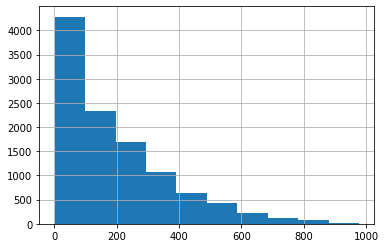

In [14]:
y_target.hist()

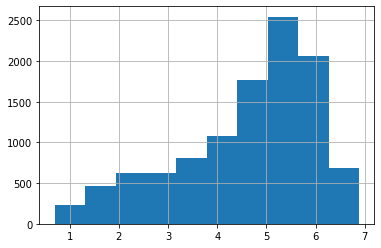

In [15]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [16]:
# 타겟 컬럼인 count 값을 log1p 로 Log 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타겟 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)


RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


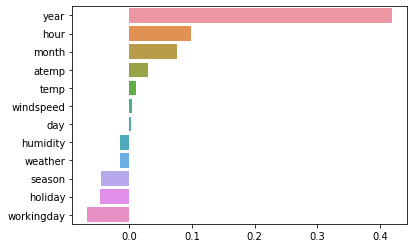

In [17]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [18]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

In [19]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict    

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)


### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


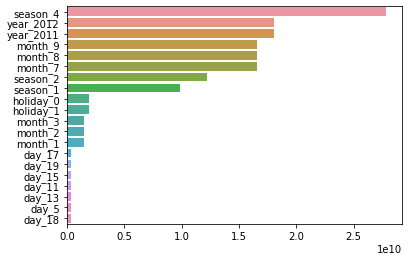

In [20]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)


In [21]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.355, RMSE: 50.332, MAE: 31.170
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.334, MAE: 32.744
[13:26:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 0.345, RMSE: 58.245, MAE: 35.768
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029
